# Function Approximators
The key notion in this lesson is that if we want to scale up to a bigger number of states we can't be using Q tables anymore: for instance if the state is an image or a Go board or a chess board. The number of possible state is way to big for a Q table. The only solution is try to understand the logic of the game, the main features that we need to take into account in order to reduce the dimension of the problem. Some approaches used handcrafted features such as Deep Blue along with an opening and closing library but handcrafted features contains too much priors on the game.

If we think about Chess one feature that comes to mind is the material count: you think that if you possess more pieces than your oponent you are in a winning position. There might be some truth in that but giving this feature to a neural network will endulge a very protective strategy, thus not enabling it to win. The only thing that matters in chess is the checkmate, no matter the number of pawns, rooks, knights, queens and bishops that you have. 

In a reinforcement learning setting you give your agent an encoded version of the board (see [here](https://arxiv.org/pdf/1712.01815.pdf) for details on how it can be achieved) and you give it a reward of 1 if it wins, a reward of -1 if it loses. You let it build its own interpretation of the environement, of the game. Free of priors, free of handcrafted features it can find the optimal policy (the convergence is not easy, but is doable as DeepMind showed us). 

Function approximators are the key to generalization: choosing the proper one (convolutionnal networks for board games for instance) can help the convergence a lot but a lot of others tricks are necessary as well to make it possible.

This lessons introduces to the use of function approximators in RL settings but the devil is in the details the solutions presented here don't always work.

## Value approximation

The goal here is to learn the function $v$ by approximating it with a parametric function $v_{\theta} : \mathcal S \rightarrow \mathbb R$, ideally we would like to minimize the square error of the difference between the two and find the best set of parameters $\theta*$:


$$
\theta* = \text{argmin}_\theta (\mathbb E _{s \in \mathcal S} [(v(s)-v_{\theta}(s))^2])
$$

However in pratice we don't have access to $v$

Thus we replace $v$ with the value of the return $G_t$ and approximate the expectancy on sampled states $S_i$:

$$
\theta* \sim \text{argmin}_\theta (\frac{1}{N}\sum_{i=1}^{N} [(G_t(S_i)-v_{\theta}(S_i))^2])\text{  } \text{  }\text{  }\text{     (1)}
$$

This return $G_t$ can be computed using Monte-Carlo or TD(0) or TD($\lambda$), in the case of TD(0) and TD($\lambda$) we need to use the function approximator to compute the target for the **bellman expectancy equation:**
$$
G_t^{(1)} = R_{t+1} + \gamma v(S_{t+1}) \sim R_{t+1} + \gamma v_{\theta}(S_{t+1})
$$


This value approximation has been used by [Tesauro's TD gammon](https://www.bkgm.com/articles/tesauro/tdl.html) to solve the Backgammon game: Once of the very first accomplishments using non-linear function approximators to master a game by self play by making gradient descent on the objective function (1)


## Action Value Approximation
In a similar fashion we can build an approximator of the action value function with sampled states and actions $(S_i,A_i)$
$$
\theta* \sim \text{argmin}_\theta (\frac{1}{N}\sum_{i=1}^{N} [(G_t(S_i,A_i)-q_{\theta}(S_i,A_i))^2]) \text{  } \text{  }\text{  } \text{     (2)}
$$
Using MC, SARSA or SARSA($\lambda$), for instance for SARSA using the **bellman optimality equation:**

$$
G_t^{(1)} = R_{t+1} + \gamma.\text{max}_{a \in \mathcal A}( q(S_{t+1},a)) \sim R_{t+1} + \gamma.\text{max}_{a \in \mathcal A}( q_{\theta}(S_{t+1},a))
$$
The best set of parameters can be found using gradient descent on (2)

## What is wrong in practice?
Following the amazing results in the previous section you might feel ready to solve all the problems on earth, yet it doesn't work: if events for learning are sampled on the flight, if the TD target is computed using the current value approximator the function has major difficulties for converging. 

Some tips/tricks have to be implemented in order to properly control the convergence and I'll review some of them here

### Experience Replay

If the good rewards are rare, meaning they occur not often at all. The gradient update will not be strong enough to push the actions towards the sequence of actions that generated the big reward. 

For Deep Q networks all the episodes are registered in a "memory" that can be used for sampling training episodes: the network is not learning on the current episode but on transitions sampled from its past experiences it allows to replay experiences that allowed it to win good rewards

### Fixed TD targets

The issue with approximating the value of the return in SARSA is that the network doesn't have the time to adapt to the new target that it already changes, therefore the key is to compute the approximation of the TD target by using a former iteration of the network. In pratice we observe that it improves drastically the convergence.


Pytorch proposes a good tutorial for building a convolutionnal Deep Q network with replay memory and fixed TD targets [here](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) I offer here my adaptation of the script of the tutorial in order to solve the mountain car problem


In [8]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# plt.ion()

#transitions that need to be stored 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    """
    Memory that will be used to replay the actions previously encountered
    allows to "remember" the past states
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class AgentLinearSarsa(nn.Module):
    """
    Module For a linear Sarsa or Neural network
    It is defined just like a pytorch module
    """
    def __init__(self,state_dim,action_dim,epsilon,epsilon_decay,gamma,learning_rate):
        super(AgentLinearSarsa,self).__init__()
        #lin is the decision module that will learn the Q function
        self.lin = nn.Sequential(nn.Linear(state_dim,50),nn.ReLU(),nn.Linear(50,action_dim))
        #self.out_lin = nn.Linear(200,action_dim)
        self.time = 0
        self._epsilon=epsilon
        self.epsilon_decay = epsilon_decay
        self.action_dim = action_dim
        self.gamma = gamma
        self.learning_rate = learning_rate

    #defining epsilon as a property for easier access with a minimum of 5%
    @property
    def epsilon(self):
        return max(self._epsilon*self.epsilon_decay**self.time,0.01)

    @epsilon.setter
    def epsilon(self,value):
        self._epsilon = value
        self.time=0

    # Function to decay epsilon    
    def decay(self):
        self.time +=1

    # forward for the pytorch module
    def forward(self,states):
        return self.lin(states)

    #epsilon greedy action selection
    def select_action(self,state):
        if random.random() < self.epsilon:
            return random.randint(0,self.action_dim-1)
        else:
            with torch.no_grad():
                processed = self(state)
                return torch.argmax(processed).item()

    #Update the network using memory, SARSA and target net
    def update(self,memory,batch_size,gamma,optimizer,target_net):
        #sampling
        transitions = memory.sample(batch_size)
        #batching
        batch = Transition(*zip(*transitions))
        #non final state need the TD error to be computed
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
        #concatenante in a pyotrch tensor all values
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        

        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            #taking the max values over all aciotion at each state
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = (next_state_values * gamma) + reward_batch
        #the "gather" is central it selects the action value of the actions formerly performed (according to memory)
        state_action_values = self(state_batch).gather(1, action_batch)

        # Compute Huber loss
        # It could have been the MSE loss but this one is giving move relevance to small errors than big errors
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # clamp to avoid gradient explosions
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()




In [9]:


# function to center position
def normalize_state(state):
    return torch.tensor(state + np.array([0.3,0]))



def run():
    #initializing environement
    env = gym.make('MountainCar-v0').unwrapped
    
    #initializing memory
    capacity = 100000
    batch_size = 128
    memory = ReplayMemory(capacity)

    #parameters agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    epsilon = 0.9
    epsilon_decay=0.98
    gamma=0.999
    learning_rate=0.01

    #init agent
    agent = AgentLinearSarsa(state_dim,action_dim,epsilon,epsilon_decay,gamma,learning_rate)
    target_net = AgentLinearSarsa(state_dim,action_dim,epsilon,epsilon_decay,gamma,learning_rate)
    target_net.load_state_dict(agent.state_dict())
    optimizer = optim.RMSprop(agent.parameters(), lr=learning_rate)
    #parameters iteration
    number_of_episodes=500
    
    for episode in range(number_of_episodes):
        #reset env
        env.reset()
        #getting first state
        state = normalize_state(env.state)
        for t in count():
            #sample action
            action = agent.select_action(state.float())
            #run env
            new_state, reward, done, _ = env.step(action)
            #get new_state
            new_state = normalize_state(new_state)
            
            # small boost that improves the behavior that decays following time (non stationnary MDP)
            if new_state[1]>0.0:
                reward += max(new_state[0].item(),0)/np.log1p(episode+1)

            #Storing transition in the memory
            memory.push(state.float().view(1,-1), torch.tensor(action).view(1,1).long(), new_state.float().view(1,-1), torch.tensor([reward]).float())
            #ready for new iterration
            state = new_state

            #update the network using SARSA
            if episode >=1:
                agent.update(memory,batch_size,gamma,optimizer,target_net)
            
            #finishing episode if it lasts too long
            if t >6000:
                break
            #displaying after 100 episodes
#            if episode > 100:
#               screen = env.render(mode='rgb_array')
            if done:
                break
        #saving agent for future display 
        torch.save(agent.state_dict(),"agent_action_value.pt")
        # Updating the network that computes the fixed TD targets
        if episode%2 == 0:
            target_net.load_state_dict(agent.state_dict())
        
        #decaying agent at the end of the episode
        agent.decay()
        # printing epsilon decay
        print("Epsilon value: ",agent.epsilon)
        #printing length of episode
        print("Length of the episode: ",t)


In [10]:
run()

Epsilon value:  0.882
Length of the episode:  6001
Epsilon value:  0.8643599999999999
Length of the episode:  6001
Epsilon value:  0.8470728
Length of the episode:  6001
Epsilon value:  0.8301313439999999
Length of the episode:  6001
Epsilon value:  0.81352871712
Length of the episode:  6001
Epsilon value:  0.7972581427776
Length of the episode:  6001
Epsilon value:  0.781312979922048
Length of the episode:  6001
Epsilon value:  0.765686720323607
Length of the episode:  5532
Epsilon value:  0.7503729859171349
Length of the episode:  4087
Epsilon value:  0.735365526198792
Length of the episode:  2788
Epsilon value:  0.7206582156748162
Length of the episode:  2394
Epsilon value:  0.7062450513613199
Length of the episode:  2903
Epsilon value:  0.6921201503340935
Length of the episode:  2644
Epsilon value:  0.6782777473274115
Length of the episode:  710
Epsilon value:  0.6647121923808634
Length of the episode:  1370
Epsilon value:  0.6514179485332461
Length of the episode:  1410
Epsilon va

Epsilon value:  0.06510769936564532
Length of the episode:  2014
Epsilon value:  0.06380554537833241
Length of the episode:  1002
Epsilon value:  0.06252943447076577
Length of the episode:  1507
Epsilon value:  0.06127884578135045
Length of the episode:  538
Epsilon value:  0.06005326886572343
Length of the episode:  329
Epsilon value:  0.05885220348840897
Length of the episode:  534
Epsilon value:  0.05767515941864079
Length of the episode:  6001
Epsilon value:  0.05652165623026797
Length of the episode:  3241
Epsilon value:  0.055391223105662614
Length of the episode:  3691
Epsilon value:  0.054283398643549356
Length of the episode:  3110
Epsilon value:  0.05319773067067837
Length of the episode:  242
Epsilon value:  0.052133776057264804
Length of the episode:  778
Epsilon value:  0.0510911005361195
Length of the episode:  4586
Epsilon value:  0.050069278525397116
Length of the episode:  2831
Epsilon value:  0.04906789295488917
Length of the episode:  237
Epsilon value:  0.0480865350

Epsilon value:  0.01
Length of the episode:  210
Epsilon value:  0.01
Length of the episode:  972
Epsilon value:  0.01
Length of the episode:  177
Epsilon value:  0.01
Length of the episode:  234
Epsilon value:  0.01
Length of the episode:  137
Epsilon value:  0.01
Length of the episode:  137
Epsilon value:  0.01
Length of the episode:  131
Epsilon value:  0.01
Length of the episode:  140
Epsilon value:  0.01
Length of the episode:  138
Epsilon value:  0.01
Length of the episode:  184
Epsilon value:  0.01
Length of the episode:  141
Epsilon value:  0.01
Length of the episode:  133
Epsilon value:  0.01
Length of the episode:  145
Epsilon value:  0.01
Length of the episode:  147
Epsilon value:  0.01
Length of the episode:  144
Epsilon value:  0.01
Length of the episode:  204
Epsilon value:  0.01
Length of the episode:  134
Epsilon value:  0.01
Length of the episode:  147
Epsilon value:  0.01
Length of the episode:  130
Epsilon value:  0.01
Length of the episode:  135
Epsilon value:  0.01

Epsilon value:  0.01
Length of the episode:  363
Epsilon value:  0.01
Length of the episode:  250
Epsilon value:  0.01
Length of the episode:  194
Epsilon value:  0.01
Length of the episode:  291
Epsilon value:  0.01
Length of the episode:  290
Epsilon value:  0.01
Length of the episode:  285
Epsilon value:  0.01
Length of the episode:  287
Epsilon value:  0.01
Length of the episode:  289
Epsilon value:  0.01
Length of the episode:  195
Epsilon value:  0.01
Length of the episode:  206
Epsilon value:  0.01
Length of the episode:  199
Epsilon value:  0.01
Length of the episode:  1135
Epsilon value:  0.01
Length of the episode:  280
Epsilon value:  0.01
Length of the episode:  281


KeyboardInterrupt: 

Once the network is trained we can plot the policy learned by the network so as to check what are the best actions to perform and the value function

In [13]:
def display_agent(agent_path):
    #initializing environement
    env = gym.make('MountainCar-v0').unwrapped

    #parameters agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    epsilon = 0.9
    epsilon_decay=0.96
    gamma=0.999
    learning_rate=0.01

    #init agent
    agent = AgentLinearSarsa(state_dim,action_dim,epsilon,epsilon_decay,gamma,learning_rate)
    
    # restauring parameters from the converged network
    state_dict = torch.load(agent_path)
    agent.load_state_dict(state_dict)

    delta = 0.025

    x =  np.arange(-.9, .9, delta)
    y = np.arange(-0.07,0.07,delta/100)

    X, Y = np.meshgrid(x, y)
    X_shape = X.shape
    input_net = np.stack([X.reshape(-1),Y.reshape(-1)],axis=1)
    output = agent(torch.tensor(input_net).float())
    Z= (torch.argmax(output,dim=1)-1).numpy()
    Z=Z.reshape(X_shape)
    plt.pcolormesh(X,Y,Z)
    plt.xlabel("Position")
    plt.ylabel("Speed")
    plt.title("Policy")
    plt.figure()
    Z2= (torch.max(output,dim=1)[0].detach()).numpy()
    Z2=Z2.reshape(X_shape)
    plt.pcolormesh(X,Y,Z2)
    plt.xlabel("Position")
    plt.ylabel("Speed")
    plt.title("Value function")
    plt.show()


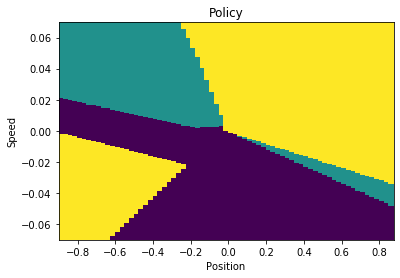

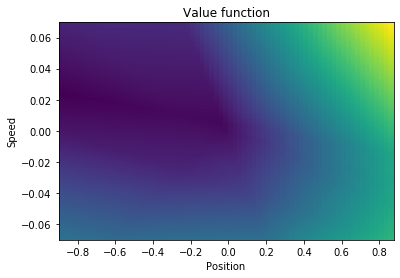

In [14]:
display_agent("agent_action_value.pt")

Both charts are in the phase space of the dynamic system

The first chart displays the optimal actions: yellow means pushing the cart forward, the purple means pushing the cart backward, the green part means applying no force on the cart. There is an interesting moment when the network figures out that leaving the momentum of the cart is useful for gaining more rewards

The second chart presents the value function of the mountain car: having no speed in the gap has low value but having high speeds at the extreme positions has high value: they allow the cart to reach the goal

Take your time to read these charts they are really interesting